In [97]:
#Load packages
library(ggplot2)
library(ISLR)
library(MASS)
library(lmtest)
library(lmtest)
library(sandwich)
library(tree)
library(randomForest)
library(rpart)
library(rpart.plot)
library(Metrics)
library(gbm)
library(xgboost)
library(leaps)
library(corrplot)
library(psych)
library(moments)
library(caret)
library(e1071)

In [98]:
#Load datafiles
load(file = 'data_final.RData')

# Data Wraggling

In [99]:
dim(data_final)

[1] 7033   26

In [100]:
#Fix naming variables
colnames(data_final)[colnames(data_final)=="perc_16+_unempl"] = "perc_16plus_unempl"
colnames(data_final)[colnames(data_final)=="perc_25+_no_school_diploma"] = "perc_25plus_no_school_diploma"

In [101]:
#Drop ZIP variable
data_final = within(data_final, rm('ZIP'))


In [102]:
summary(data_final)

  community_no       PRICE         PROPERTY_TYPE           BEDS       
 Min.   : 1.00   Min.   :  50000   Length:7033        Min.   : 0.000  
 1st Qu.: 8.00   1st Qu.: 232000   Class :character   1st Qu.: 2.000  
 Median :17.00   Median : 400000   Mode  :character   Median : 3.000  
 Mean   :24.53   Mean   : 626091                      Mean   : 2.914  
 3rd Qu.:33.00   3rd Qu.: 682500                      3rd Qu.: 4.000  
 Max.   :77.00   Max.   :8299000                      Max.   :12.000  
     BATHS         SQUARE_FEET      LOCATION           YEAR_BUILT  
 Min.   : 1.000   Min.   :  400   Length:7033        Min.   :1850  
 1st Qu.: 1.500   1st Qu.: 1182   Class :character   1st Qu.:1925  
 Median : 2.000   Median : 1600   Mode  :character   Median :1969  
 Mean   : 2.263   Mean   : 1936                      Mean   :1966  
 3rd Qu.: 3.000   3rd Qu.: 2300                      3rd Qu.:2005  
 Max.   :10.500   Max.   :17769                      Max.   :2020  
     URL               LATI

In [103]:
names(data_final)

[1] "community_no"                  "PRICE"                        
 [3] "PROPERTY_TYPE"                 "BEDS"                         
 [5] "BATHS"                         "SQUARE_FEET"                  
 [7] "LOCATION"                      "YEAR_BUILT"                   
 [9] "URL"                           "LATITUDE"                     
[11] "LONGITUDE"                     "min_dist_cta"                 
[13] "num_cta_1mile"                 "crime_per_1000"               
[15] "life_exp_2010"                 "unemployment"                 
[17] "perc_housing_crowded"          "perc_household_below_poverty" 
[19] "perc_16plus_unempl"            "perc_25plus_no_school_diploma"
[21] "perc_under18_over64"           "income_per_capite"            
[23] "hardship_index"                "percent_level1_school"        
[25] "percent_level2_school"

In [104]:
data_final$community_no = as.factor(data_final$community_no)
#data_final$BEDS = as.factor(data_final$BEDS)
#data_final$BATHS = as.factor(data_final$BATHS)
data_final$PROPERTY_TYPE = as.factor(data_final$PROPERTY_TYPE)
data_final$LOCATION = as.factor(data_final$LOCATION)

## Resolve community variable

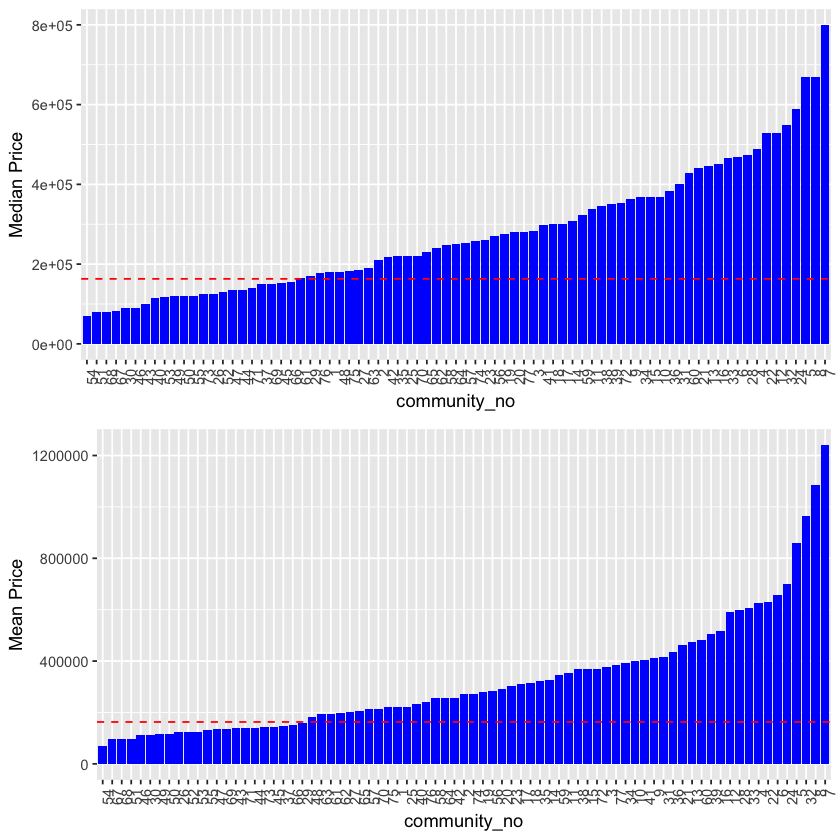

In [105]:
#Resolve community variables (too many categories)
nb1 = ggplot(data_final, aes(x=reorder(community_no, PRICE, FUN=median), y=PRICE)) +
        geom_bar(stat='summary', fun.y = "median", fill='blue') + labs(x='community_no', y='Median Price') +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        geom_hline(yintercept=163000, linetype="dashed", color = "red") #dashed line is median SalePrice

nb2 = ggplot(data_final, aes(x=reorder(community_no, PRICE, FUN=mean), y=PRICE)) +
        geom_bar(stat='summary', fun.y = "mean", fill='blue') + labs(x='community_no', y="Mean Price") +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        geom_hline(yintercept=163000, linetype="dashed", color = "red") #dashed line is median SalePrice

grid.arrange(nb1, nb2)

In [106]:
mean_p_community = aggregate( PRICE ~ community_no, data_final, mean )
mean_p_community[order(-mean_p_community$PRICE),][1:11,]

,community_no,PRICE
7,7,1240609.7
8,8,1085969.7
32,32,965808.4
5,5,861406.2
24,24,700320.1
6,6,658857.6
22,22,631683.8
4,4,624669.4
33,33,606307.8
28,28,598055.1


In [107]:
med_p_community = aggregate( PRICE ~ community_no, data_final, median )
med_p_community[order(-med_p_community$PRICE),][1:11,]

,community_no,PRICE
7,7,799450
5,5,669000
8,8,669000
24,24,589450
32,32,549900
12,12,529900
22,22,529450
4,4,489000
28,28,474000
6,6,469000


In [108]:
#Create categories for the extremes
data_final$NeighRich[data_final$community_no %in% c(7,8,32,5,24,6,22,4,33,28,12)] = 2
data_final$NeighRich[!data_final$community_no %in% c(54,67,68,51,46,30,7,8,32,5,24,6,22,4,33,28,12)] = 1
data_final$NeighRich[data_final$community_no %in% c(54,67,68,51,46,30)] = 0

In [109]:
table(data_final$NeighRich, data_final$community_no)

   
       1    2    3    4    5    6    7    8    9   10   11   12   13   14   15
  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  1  114  149  150    0    0    0    0    0   48  100   54    0   27   62  106
  2    0    0    0  103  161  512  502 1129    0    0    0   81    0    0    0
   
      16   17   18   19   20   21   22   23   24   25   26   27   28   29   30
  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    7
  1  141  123   28   62   15   64    0   34    0   68    5   14    0    8    0
  2    0    0    0    0    0    0  198    0  478    0    0    0  268    0    0
   
      31   32   33   34   35   36   37   38   39   40   41   42   43   44   45
  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  1   29    0    0    9   27   12    3   79   61    6   70   29   59   43   27
  2    0  341  210    0    0    0    0    0    0    0    0    0    0    0    0
   
      46   47   48   49   50   51   

In [110]:
#Factor NeighRich
data_final$NeighRich = as.factor(data_final$NeighRich)

## Resolve YEAR_BUILT variable

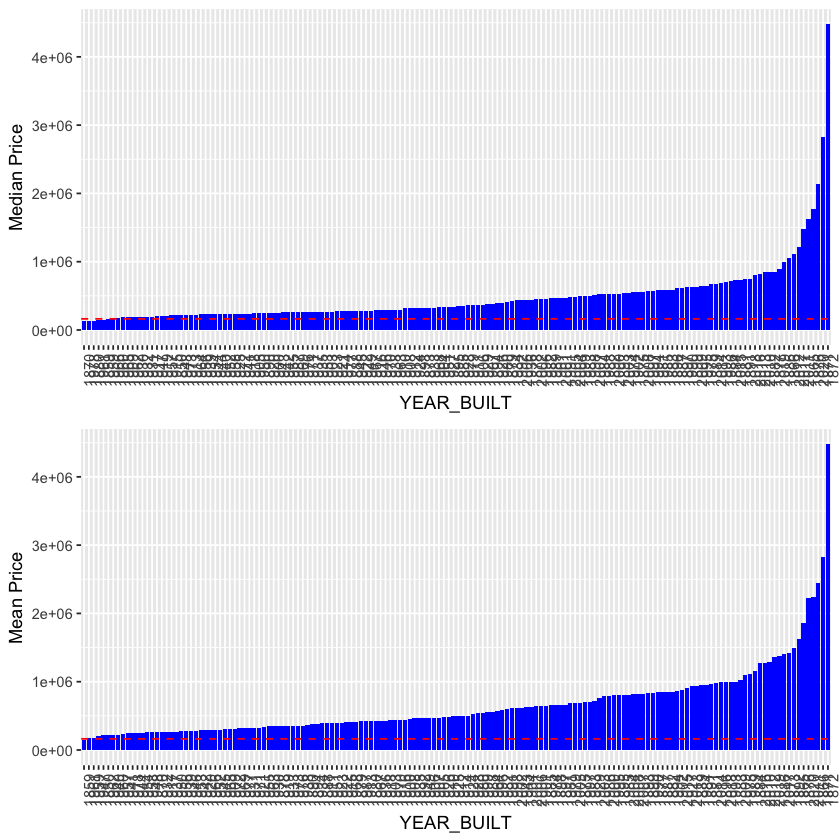

In [111]:
y1 = ggplot(data_final, aes(x=reorder(YEAR_BUILT, PRICE, FUN=median), y=PRICE)) +
        geom_bar(stat='summary', fun.y = "median", fill='blue') + labs(x='YEAR_BUILT', y='Median Price') +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        geom_hline(yintercept=163000, linetype="dashed", color = "red") #dashed line is median SalePrice

y2 = ggplot(data_final, aes(x=reorder(YEAR_BUILT, PRICE, FUN=mean), y=PRICE)) +
        geom_bar(stat='summary', fun.y = "mean", fill='blue') + labs(x='YEAR_BUILT', y="Mean Price") +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        geom_hline(yintercept=163000, linetype="dashed", color = "red") #dashed line is median SalePrice


grid.arrange(y1, y2)

In [112]:
# Create a new variable: Age of the building
# current (time data was retrieved) - year built
data_final$HouseAge = data_final$YEAR_BUILT
data_final$HouseAge = sapply(data_final$HouseAge, function(x) 2018 - x)


In [113]:
summary(data_final$HouseAge)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  -2.00   13.00   49.00   52.43   93.00  168.00 

In [114]:
#Put Year_Built back to factor
data_final$YEAR_BUILT = as.factor(data_final$YEAR_BUILT)

## Check other variables

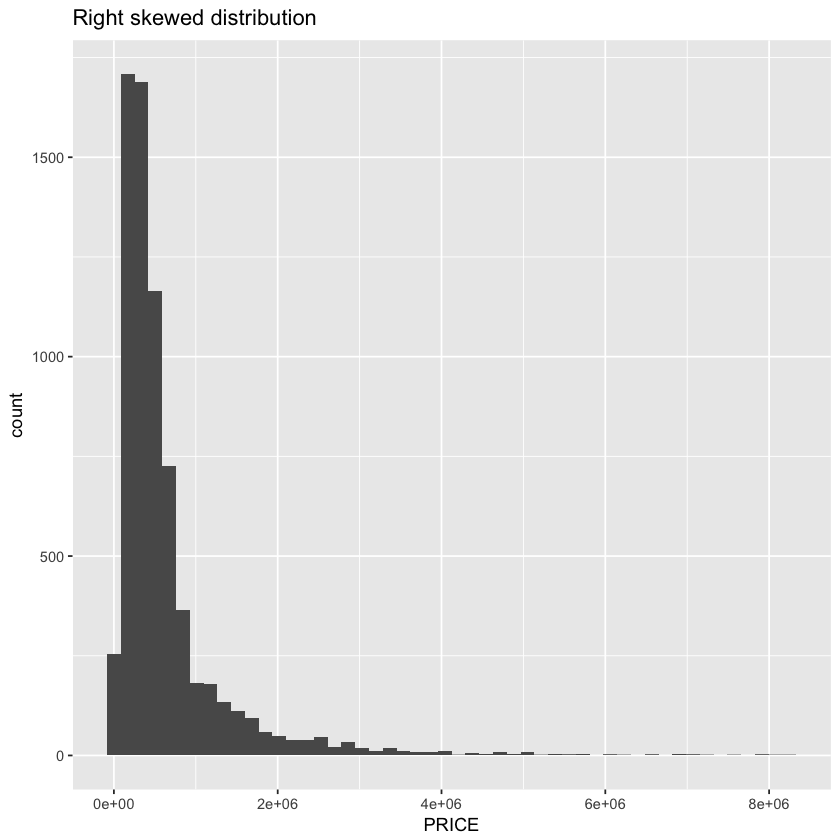

In [115]:
qplot(PRICE, data = data_model_f, bins = 50, main = "Right skewed distribution")

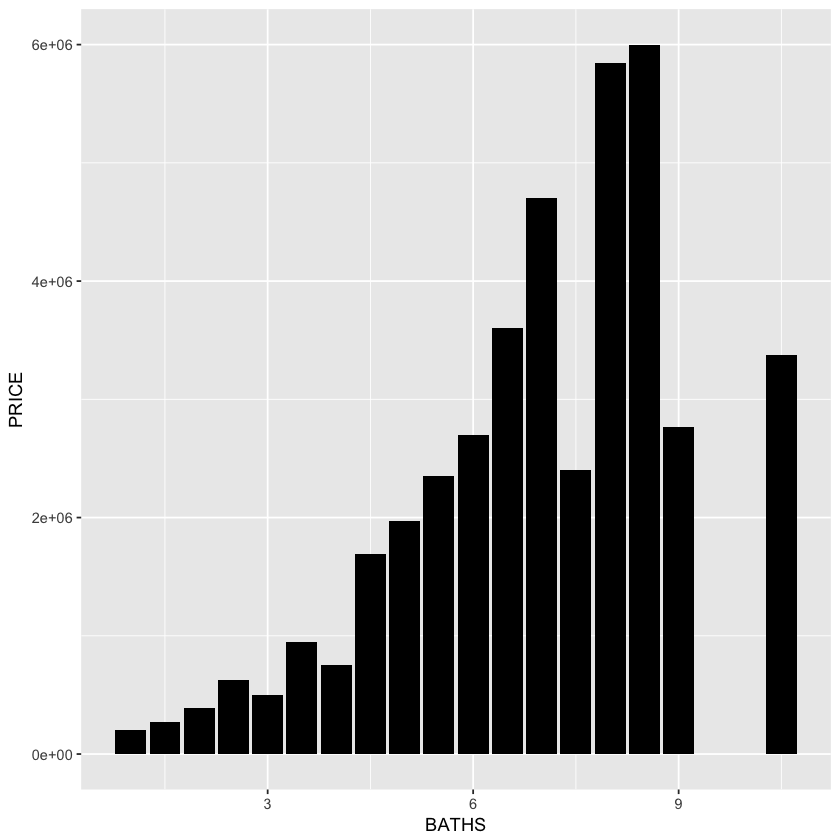

In [116]:
ggplot(data_final, aes(x=BATHS, y=PRICE)) +
        geom_bar(stat='summary', fun.y = "median", fill='black')

In [117]:
numericVars = which(sapply(data_final, is.numeric))
factorVars = which(sapply(data_final, is.factor))
cat('There are', length(numericVars), 'numeric variables, and', length(factorVars), 'categoric variables')

There are 21 numeric variables, and 5 categoric variables

In [118]:
#Geting numeric variables
numericVars = data_final[,numericVars] #index vector numeric variables
numericVarNames = names(numericVars) #saving names vector for use later on
numericVarNames

[1] "PRICE"                         "BEDS"                         
 [3] "BATHS"                         "SQUARE_FEET"                  
 [5] "LATITUDE"                      "LONGITUDE"                    
 [7] "min_dist_cta"                  "num_cta_1mile"                
 [9] "crime_per_1000"                "life_exp_2010"                
[11] "unemployment"                  "perc_housing_crowded"         
[13] "perc_household_below_poverty"  "perc_16plus_unempl"           
[15] "perc_25plus_no_school_diploma" "perc_under18_over64"          
[17] "income_per_capite"             "hardship_index"               
[19] "percent_level1_school"         "percent_level2_school"        
[21] "HouseAge"

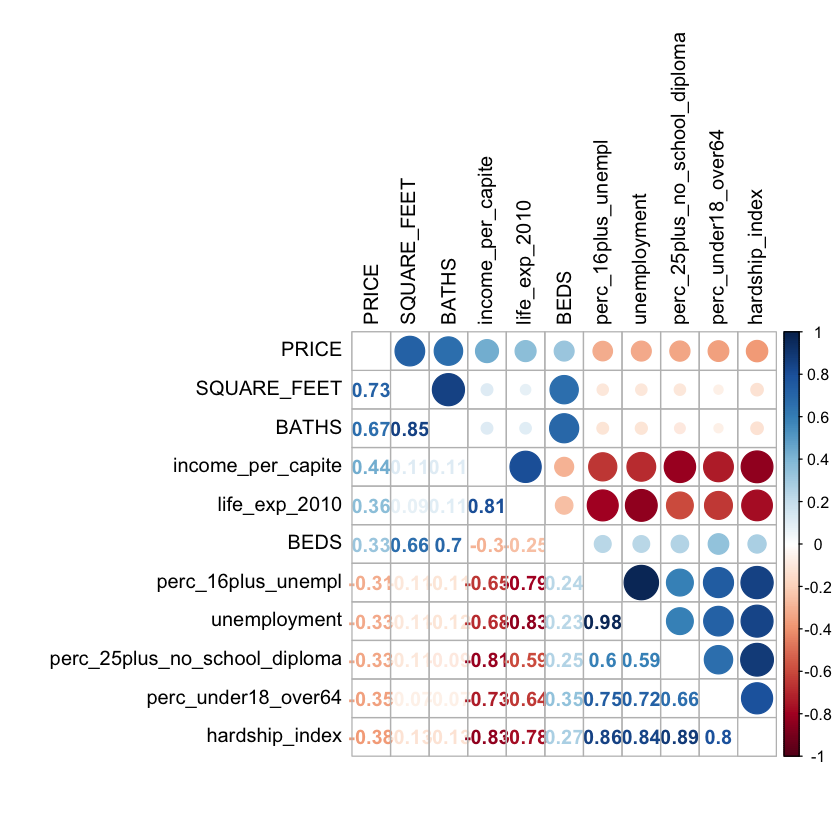

In [119]:
#Check correlation on all numeric variables
cor_numVar = cor(numericVars, use="pairwise.complete.obs") 

#sort on decreasing correlations with PRICE
cor_sorted = as.matrix(sort(cor_numVar[,'PRICE'], decreasing = TRUE))
 #select only high corelations
CorHigh = names(which(apply(cor_sorted, 1, function(x) abs(x)>0.3)))
cor_numVar = cor_numVar[CorHigh, CorHigh]

corrplot.mixed(cor_numVar, tl.col="black", tl.pos = "lt")

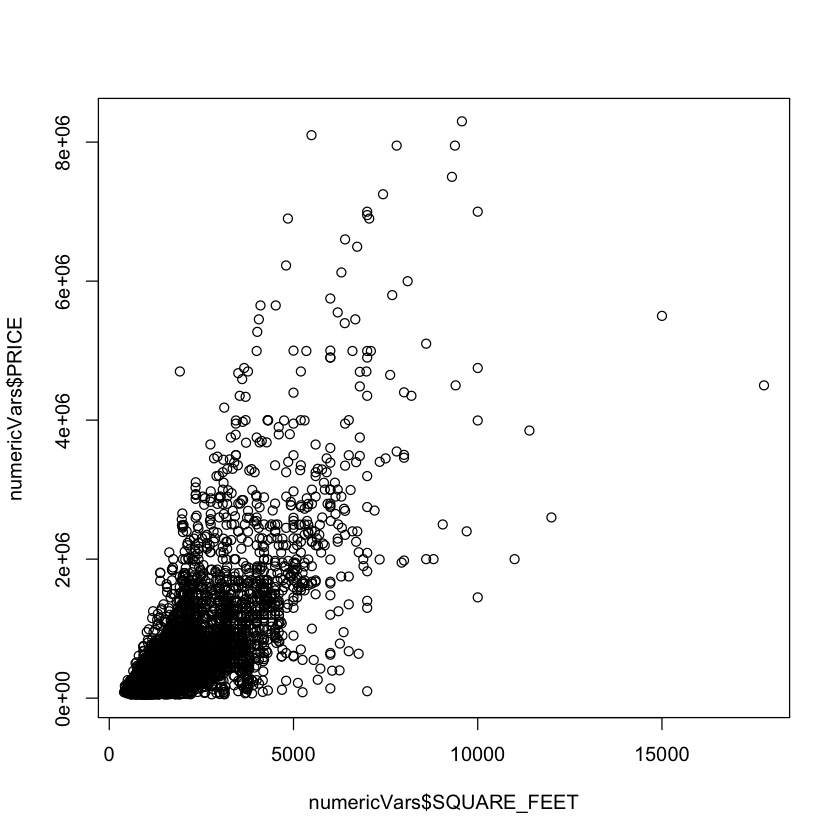

In [120]:
plot(numericVars$SQUARE_FEET, numericVars$PRICE)

In [121]:
#Drop some variables
data_final2 = within(data_final, rm('LOCATION','YEAR_BUILT','URL'))

In [122]:
names(data_final2)

[1] "community_no"                  "PRICE"                        
 [3] "PROPERTY_TYPE"                 "BEDS"                         
 [5] "BATHS"                         "SQUARE_FEET"                  
 [7] "LATITUDE"                      "LONGITUDE"                    
 [9] "min_dist_cta"                  "num_cta_1mile"                
[11] "crime_per_1000"                "life_exp_2010"                
[13] "unemployment"                  "perc_housing_crowded"         
[15] "perc_household_below_poverty"  "perc_16plus_unempl"           
[17] "perc_25plus_no_school_diploma" "perc_under18_over64"          
[19] "income_per_capite"             "hardship_index"               
[21] "percent_level1_school"         "percent_level2_school"        
[23] "NeighRich"                     "HouseAge"

## Try feature selection with RF

In [123]:
#Use Random forest for feature selection
set.seed(123)
quick_RF = randomForest(PRICE~., data = data_final2[,-1], ntree = 100, importance = TRUE)
imp_RF = importance(quick_RF)
imp_DF = data.frame(Variables = row.names(imp_RF), MSE = imp_RF[,1])
imp_DF = imp_DF[order(imp_DF$MSE, decreasing = TRUE),]


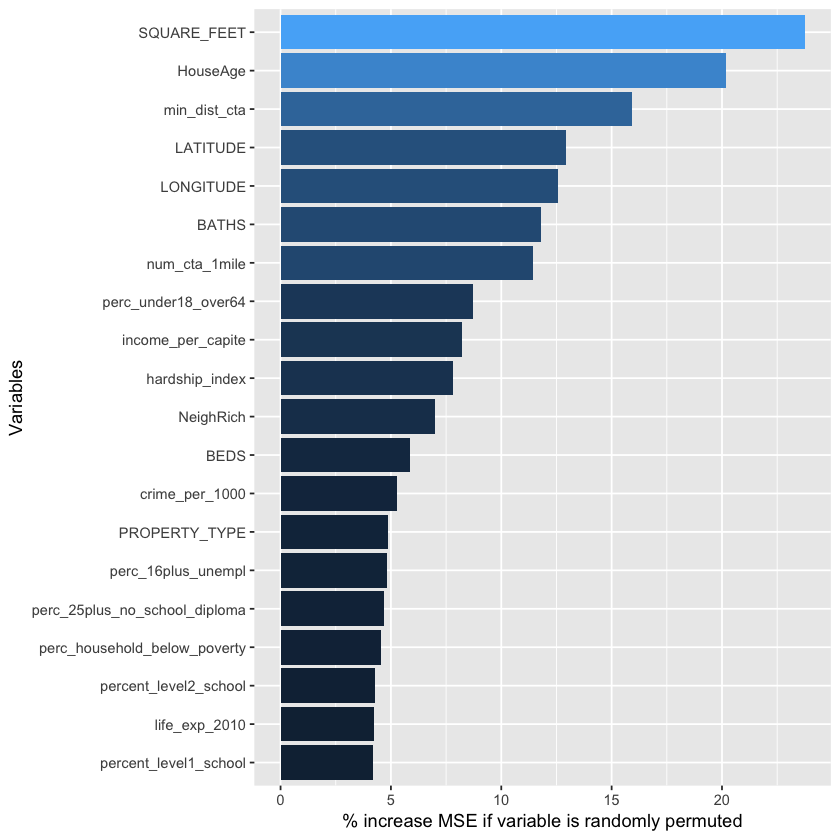

In [124]:
ggplot(imp_DF[1:20,], aes(x=reorder(Variables, MSE), y=MSE, fill = MSE)) +
    geom_bar(stat = 'identity') + coord_flip() +
    labs(x = 'Variables', y= '% increase MSE if variable is randomly permuted') +
    theme(legend.position="none")



## Preprocess variables

In [125]:
#Check skewness of numeric predictors:
skewed_stats = c()
var_names = c()
for (i in 1:ncol(numericVars)){
    skewed_stats = append(skewed_stats,abs(skew(numericVars[,i])))
    var_names = append(var_names, numericVarNames[i])
}

skewed_DF = data.frame(cbind(var_names, skewed_stats))
skewed_DF = skewed_DF[order(skewed_DF$skewed_stats, decreasing = TRUE),]

In [126]:
skewed_DF

,var_names,skewed_stats
1,PRICE,3.85898998836895
4,SQUARE_FEET,2.60484275160139
8,num_cta_1mile,2.53123188202575
12,perc_housing_crowded,2.03562423893446
11,unemployment,1.98795278796629
9,crime_per_1000,1.8421187254943
14,perc_16plus_unempl,1.79952755435272
3,BATHS,1.33273115547149
13,perc_household_below_poverty,1.31915888706437
15,perc_25plus_no_school_diploma,1.26761861079713


In [127]:
#Set a new dataset before fixing skewness
data_final3 = data_final2

In [128]:
skewness(data_final3$SQUARE_FEET)

[1] 2.604843

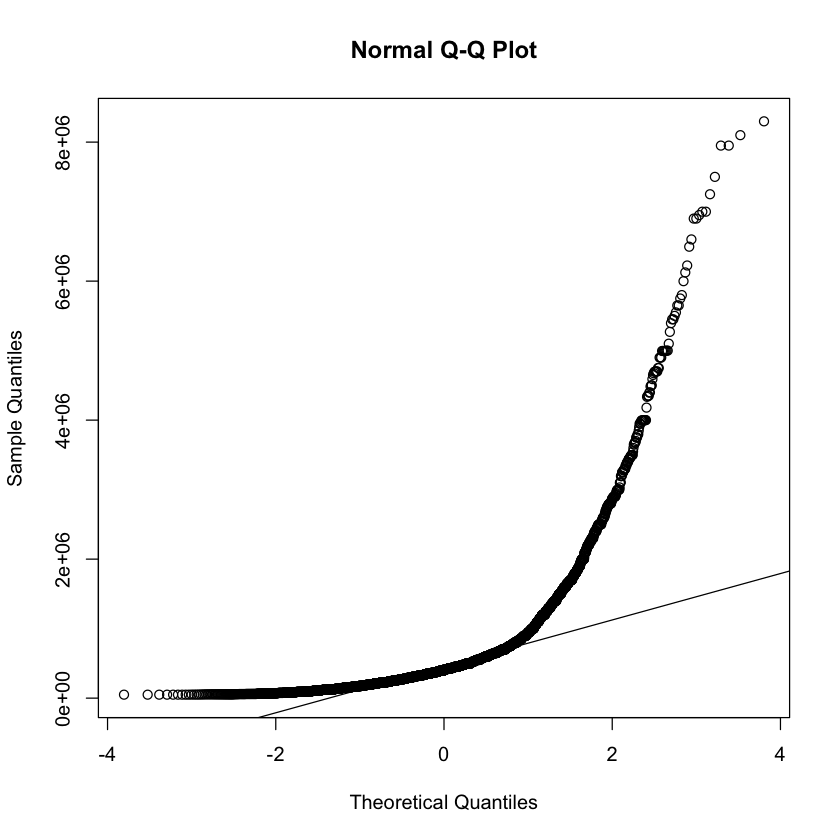

In [129]:
qqnorm(data_final3$PRICE)
qqline(data_final3$PRICE)

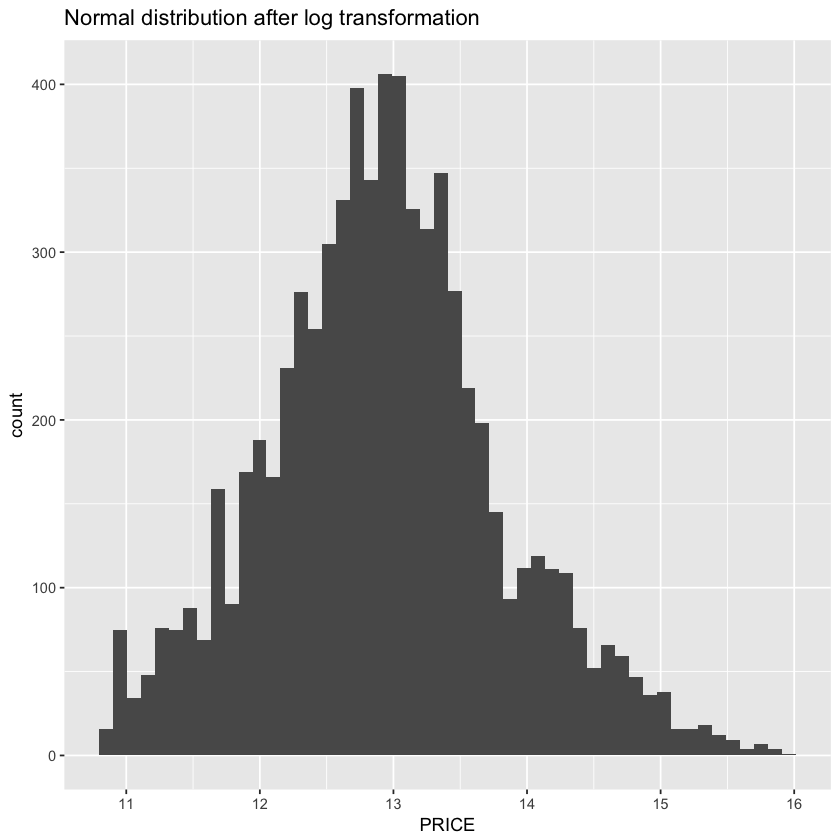

In [130]:
## Log transformation of the target variable
#data_final3$PRICE = log(data_final3$PRICE + 1)
data_final3$PRICE = log(data_final3$PRICE)

## Normal distribution after transformation
qplot(PRICE, data = data_final3, bins = 50, main = "Normal distribution after log transformation")

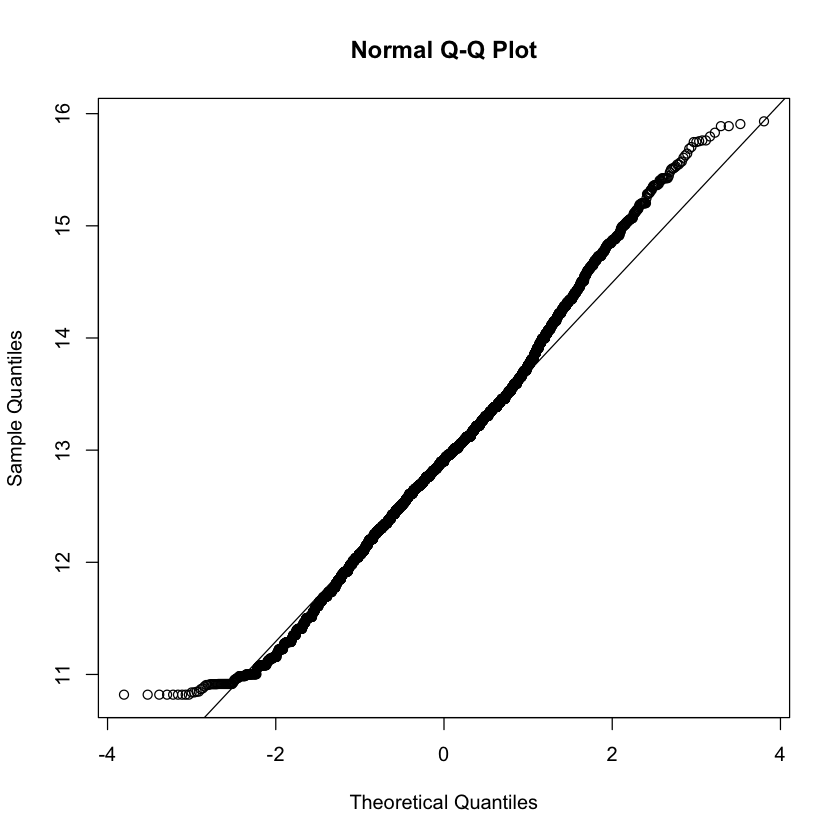

In [131]:
qqnorm(data_final3$PRICE)
qqline(data_final3$PRICE)

### Convert one hot encoding

In [132]:
factorVars = which(sapply(data_final3, is.factor))
dummies = dummyVars(~., data_final3[names(factorVars)[-1]])
data_dmy = predict(dummies, data_final3[names(factorVars)[-1]])
data_model = cbind(data_final3, data_dmy)

In [134]:
names(data_model)

[1] "community_no"                           
 [2] "PRICE"                                  
 [3] "PROPERTY_TYPE"                          
 [4] "BEDS"                                   
 [5] "BATHS"                                  
 [6] "SQUARE_FEET"                            
 [7] "LATITUDE"                               
 [8] "LONGITUDE"                              
 [9] "min_dist_cta"                           
[10] "num_cta_1mile"                          
[11] "crime_per_1000"                         
[12] "life_exp_2010"                          
[13] "unemployment"                           
[14] "perc_housing_crowded"                   
[15] "perc_household_below_poverty"           
[16] "perc_16plus_unempl"                     
[17] "perc_25plus_no_school_diploma"          
[18] "perc_under18_over64"                    
[19] "income_per_capite"                      
[20] "hardship_index"                         
[21] "percent_level1_school"                  
[22] "percent_level2_school"                  
[23] "NeighRich"                              
[24] "HouseAge"                               
[25] "PROPERTY_TYPE.Condo/Co-op"              
[26] "PROPERTY_TYPE.Single Family Residential"
[27] "PROPERTY_TYPE.Townhouse"                
[28] "NeighRich.0"                            
[29] "NeighRich.1"                            
[30] "NeighRich.2"

In [135]:
#Drop baseline variables
#data_model = within(data_model, rm('BEDS','BATHS','PROPERTY_TYPE','NeighRich'))
data_model = within(data_model, rm('PROPERTY_TYPE','NeighRich'))

dim(data_model)
names(data_model)

[1] 7033   28

[1] "community_no"                           
 [2] "PRICE"                                  
 [3] "BEDS"                                   
 [4] "BATHS"                                  
 [5] "SQUARE_FEET"                            
 [6] "LATITUDE"                               
 [7] "LONGITUDE"                              
 [8] "min_dist_cta"                           
 [9] "num_cta_1mile"                          
[10] "crime_per_1000"                         
[11] "life_exp_2010"                          
[12] "unemployment"                           
[13] "perc_housing_crowded"                   
[14] "perc_household_below_poverty"           
[15] "perc_16plus_unempl"                     
[16] "perc_25plus_no_school_diploma"          
[17] "perc_under18_over64"                    
[18] "income_per_capite"                      
[19] "hardship_index"                         
[20] "percent_level1_school"                  
[21] "percent_level2_school"                  
[22] "HouseAge"                               
[23] "PROPERTY_TYPE.Condo/Co-op"              
[24] "PROPERTY_TYPE.Single Family Residential"
[25] "PROPERTY_TYPE.Townhouse"                
[26] "NeighRich.0"                            
[27] "NeighRich.1"                            
[28] "NeighRich.2"

## Compose Train and Test sets

In [136]:
#Split train set into train and validation set: train 90% and validation 10%
set.seed(123)
train = sample(dim(data_model)[1], dim(data_model)[1]*0.8 )
trainData = data_model[train,]
testData = data_model[-train,]

In [137]:
dim(trainData)
dim(testData)

[1] 5626   28

[1] 1407   28

In [138]:
#Save data
save(data_model, file = 'data/newdata/data_model2.RData')
save(trainData, file = 'data/newdata/trainData2.RData')
save(testData, file = 'data/newdata/testData2.RData')